# Classification

## Problem Framing

This is Multi-Class classification problem: Only 1 output of more than 2 posibility at a time.

NOT Multi-Lable classification problem: Can have multiple output classes at once.

NOT Binary classification problem: Only 1 output of 2 posibiltiy at a time.

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

### Load data

In [3]:
# Load iris dataset
from sklearn import datasets

data = datasets.load_iris()

In [4]:
# Create DataFrame with column names
df = pd.DataFrame(data["data"], columns=data['feature_names'])

In [5]:
# Replace encoder target to ogirinal string
target_df = pd.DataFrame(data['target'], columns=['target'])
replace_dict = dict(zip(range(len(data['target_names'])), data['target_names']))
# Merge them to main features df
df['target'] = target_df.replace(replace_dict)

In [6]:
# Take a look
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Analyse

In [7]:
# Check for null and catagory value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Encoding is needed for 'target'

In [8]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Data scaling is needed

### Check samples skewness

Model tend to bias toward sample that have higher no. plase ensure the no. of sample is equal.

<AxesSubplot:xlabel='target', ylabel='count'>

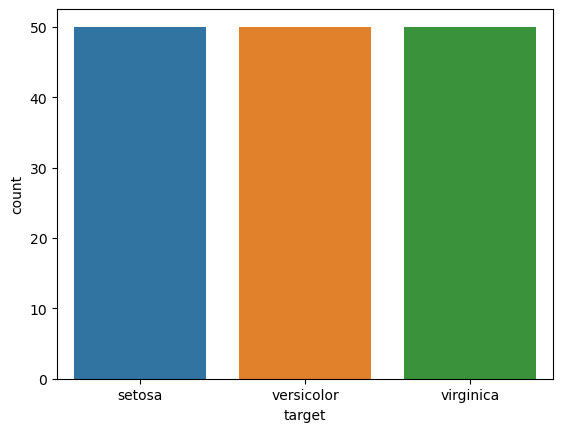

In [9]:
sns.countplot(data=df, x='target')

Every target samples are equal. No skewness!

### Visualize

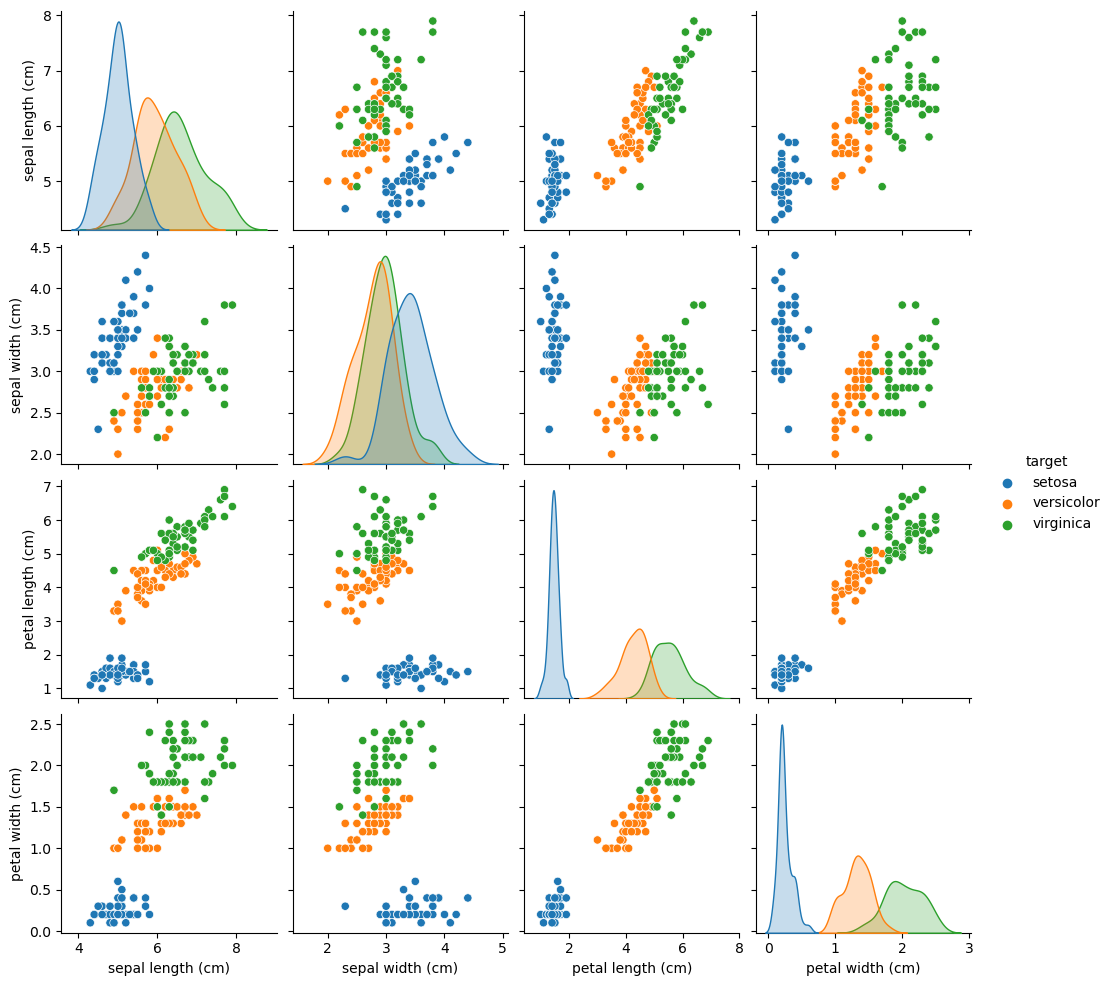

In [10]:
sns.pairplot(data=df, hue='target')

It seem _setosa_ is easy to seperate, it will sure having a greate score, but not for versicolor and virginica.

## Preprocession

### Encoding

In [11]:
# Encoding the label
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

label = 'target'
df[label] = enc.fit_transform(df[label])

X = df.drop(label, axis=1)
y = df[label]


### Train test split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=24, stratify=y)

### Train the model

In [13]:
# from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(), OneVsRestClassifier(SVC(random_state=0)))
clf_SVC_linear = SVC(kernel='linear', C=1, decision_function_shape='ovo')
clf_tree = tree.DecisionTreeClassifier()
clf_forest = RandomForestClassifier()
clf_cluster = KMeans(n_clusters=len(enc.classes_))
clf_knn = KNeighborsClassifier(n_neighbors=len(enc.classes_))


models = [pipe, clf_SVC_linear, clf_tree, clf_forest, clf_cluster, clf_knn]


def train_models(models, X, y):
    for model in models:
        model.fit(X, y)
        
        
train_models(models, X_train, y_train)

## Prediction

In [14]:
def predict_models(models, X):
    
    pred = {}
    
    for model in models:
        pred[str(model)] = model.predict(X)
    
    return pred
        

y_preds = predict_models(models, X_test)

## Evaluate

### Precision, Recall and F1 score

In [15]:
from sklearn.metrics import classification_report


def models_clf_report(y_preds, y_test):
    
    for model, y_pred in y_preds.items():
        
        print(f'Model {str(model)} \n', classification_report(y_test, y_pred))
       

models_clf_report(y_preds, y_test)

Model Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=SVC(random_state=0)))]) 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Model SVC(C=1, decision_function_shape='ovo', kernel='linear') 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Model score ranking
1. SVC(linear)
2. Pipeline, RandomForest
3. DecisionTree
4. KMean cluster

To ensure it generalized well, we're going to use `cross_val_score` to score them again.

### Cross valuation score

In [16]:
from sklearn.model_selection import cross_val_score

def models_cvs(models, X, y, cv):
    for model in models:
        scores = cross_val_score(model, X, y, cv=cv)
        print('{}: accuracy {}, standard deviation: {}'.format(str(model), scores.mean(), scores.std()))
    
models_cvs(models, X, y, cv=5)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=SVC(random_state=0)))]): accuracy 0.9666666666666666, standard deviation: 0.02108185106778919
SVC(C=1, decision_function_shape='ovo', kernel='linear'): accuracy 0.9800000000000001, standard deviation: 0.016329931618554516
DecisionTreeClassifier(): accuracy 0.9600000000000002, standard deviation: 0.03265986323710903
RandomForestClassifier(): accuracy 0.96, standard deviation: 0.024944382578492935
KMeans(n_clusters=3): accuracy -17.23796412933894, standard deviation: 4.945204251902471
KNeighborsClassifier(n_neighbors=3): accuracy 0.9666666666666668, standard deviation: 0.02108185106778919


Cleary `SVC(linear)` is the best model

In [17]:
best_clf = clf_SVC_linear

## Error Analysis

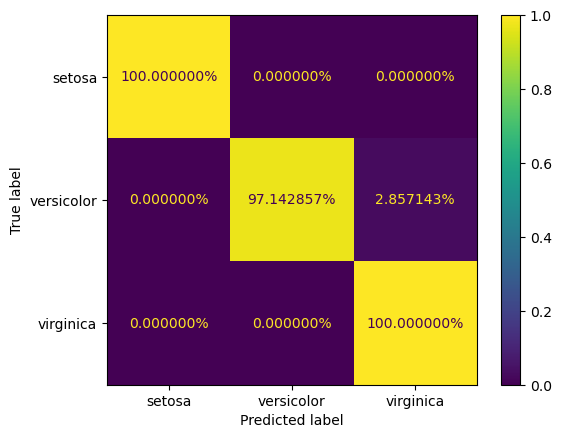

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict


y_train_pred = cross_val_predict(best_clf, X_train, y_train, cv=3)

# sample_weight = (y_train_pred != y_train)
y_train_name, y_train_pred_name = enc.inverse_transform(y_train), enc.inverse_transform(y_train_pred)

ConfusionMatrixDisplay.from_predictions(y_train_name, y_train_pred_name, 
                                        normalize='true',
                                        values_format='0%')

plt.show()

As expected, _setosa_ have 100% precision. and the rest have acceptable score.

### Visuialization Error

#### Plot and highlight misclassification data.

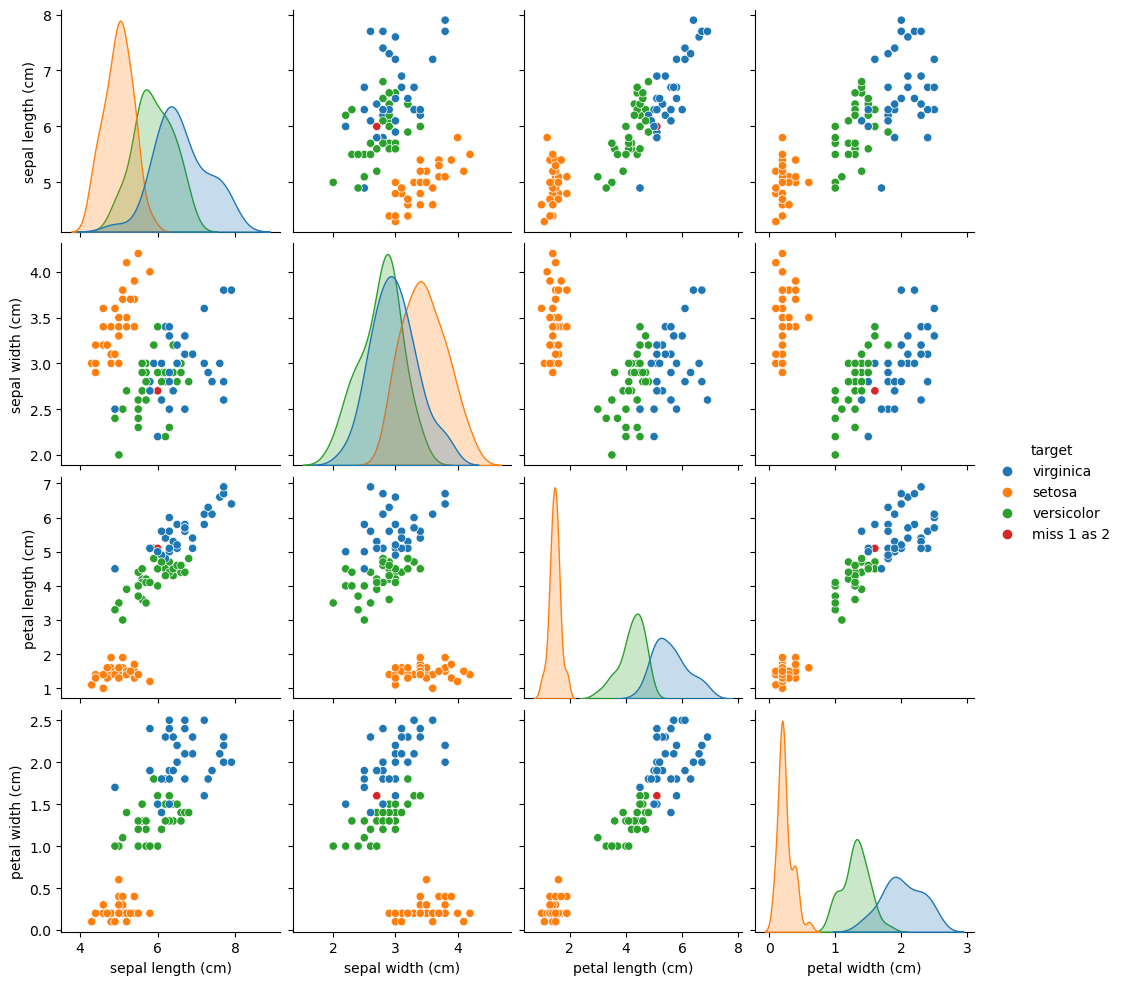

In [19]:
# Mark the misclassification data.
df_eval = X_train.copy()
y_train_preds_name = enc.inverse_transform(y_train_pred)
y_train_name = enc.inverse_transform(y_train)

df_eval['pred'] = y_train_preds_name
df_eval['target'] = y_train_name

df_eval.loc[(y_train == 1) & (y_train_pred == 2), 'target'] = 'miss 1 as 2'
df_eval.loc[(y_train == 2) & (y_train_pred == 1), 'target'] = 'miss 2 as 1'

sns.pairplot(data=df_eval, hue='target')
plt.show()
# df_eval[df_eval['target'] == 'miss 2 as 1']

### Plot Hyperplane
Can't use this method if there are more than 3 dimenstion features.

We create mesh grid.
Then predict all mesh value in grid.
Then plot those output. We will get the plane with color for each _w_.

/Users/krit/homebrew/Caskroom/miniforge/base/envs/mlp-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


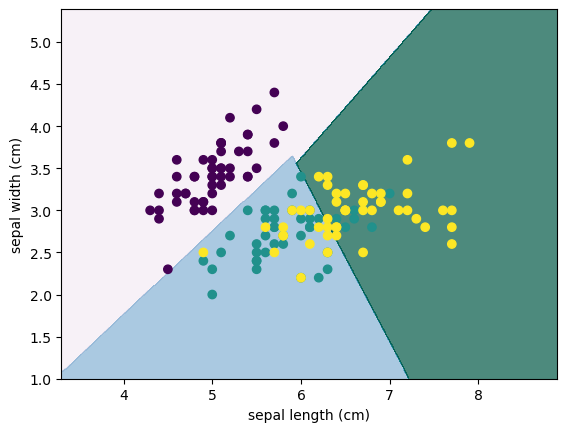

In [22]:
# Since human can not understand space more than 3 dimensions, we're going to plot 2 dimensions graph using 2 features.
clf = SVC(kernel='linear', C=1, decision_function_shape='ovo')
XX = X.iloc[:,[0, 1]]
clf.fit(XX, y)
y_pred = clf.predict(XX)

# Resolution or stepsize in mesh
h = .01
#create the mesh
x_min, x_max = XX.iloc[:,0].min() - 1, XX.iloc[:,0].max() + 1
y_min, y_max = XX.iloc[:,1].min() - 1, XX.iloc[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

# Plot
# np.c_ 2D mesh array to 1D mesh for calculate prediction
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn, alpha=0.7)
# Plot also the training points
plt.scatter(XX.iloc[:, 0], XX.iloc[:, 1], c=y)
plt.xlabel(XX.columns[0])
plt.ylabel(XX.columns[1])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

### Alternatively plot with `DecisionBoundaryDisplay`

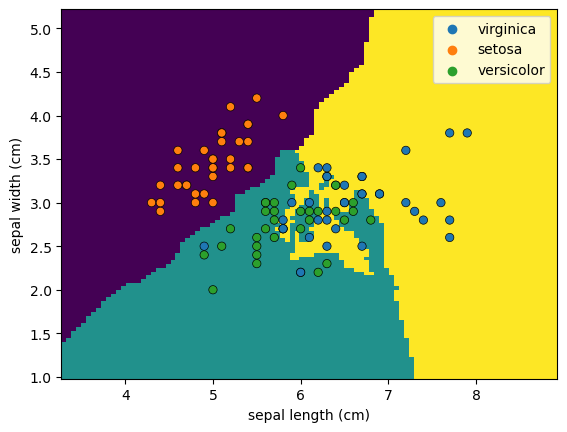

In [56]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

clf_plot = KNeighborsClassifier(n_neighbors=3)
clf_plot.fit(X_train.iloc[:,:2], y_train)

_, ax = plt.subplots()

# Plot the decision boundary

DecisionBoundaryDisplay.from_estimator(
    clf_plot,
    X_train.iloc[:,:2],
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel=data.feature_names[0],
    ylabel=data.feature_names[1],
    shading="auto",
)

# Plot the training points
sns.scatterplot(
    x=X_train.iloc[:,0],
    y=X_train.iloc[:,1],
    hue=enc.inverse_transform(y_train),
    alpha=1.0,
    edgecolor="black",
    ax=ax
)

## Multilabel Classification

We can train the model with multiple y label and return multilabel classification

In [48]:
from sklearn.metrics import f1_score

# Train with multiple target instead of 1
y_train_1 = (y_train == 1)
y_train_2 = (y_train == 2)
y_train_3 = (y_train == 3)

y_multilabel = np.c_[y_train_1, y_train_2, y_train_3]
    
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_neighbors=3)

In [49]:
knn_clf.predict(X_test)

array([[False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False],
       [False, False, False],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [Fa

In [50]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/Users/krit/homebrew/Caskroom/miniforge/base/envs/mlp-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.6190378988909301

In [54]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=3)
multi_target_forest.fit(X_train, y_multilabel).predict(X_test)

array([[False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [ True,  True, False],
       [False, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False, False],
       [False, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False],
       [False, False, False],
       [ True, False, False],
       [False, False, False],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [Fa

In [55]:
y_train_forest_pred = cross_val_predict(multi_target_forest, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_forest_pred, average="macro")

/Users/krit/homebrew/Caskroom/miniforge/base/envs/mlp-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.5902265902265902

# Create deploy function

In [ ]:
def iris_classification(X):
    return list(enc.inverse_transform(best_clf.predict(X)))


iris_classification(X.iloc[[1, 20, 99, 149]])

['setosa', 'setosa', 'versicolor', 'virginica']